# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: A. Gramfort, M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal coordinate descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 1st of december at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 5 novembre 2018**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [2]:
# Change here using YOUR first and last names
fn1 = "seyni"
ln1 = "diop"
fn2 = "bakary"
ln2 = "sidibé"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_diop_seyni_and_sidibé_bakary.ipynb


In [0]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [0]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b

## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$

We ask you to code:
- cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$
- greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.


**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [0]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [0]:
lips_const = np.linalg.norm(A, axis=0) ** 2

In [0]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO
    
    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j]
        w[j] += 1/lips_const[j] * A[:,j].T@residuals
        # update residuals:
        residuals = b - A.dot(w)
        # END TODO
        
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    # TODO
    residuals = b - A.dot(w)
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = np.argmax(np.abs(gradient))
        old_w_j = w[j]
        w[j] += 1/lips_const[j] * A[:,j].T@residuals
        # update gradient:
        #gradient = A.T.dot(A.dot(w) - b)
        gradient += gram[:,j]*(w[j]- old_w_j)
        residuals = b - A.dot(w)
        # END TODO
        
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    
    return w, np.array(all_objs)

- compute a precise minimum with your favorite solver
- compare the performance of cyclic and greedy CD

- from a practical point of view, could you use greedy CD for ridge logistic regression? to solve OLS, but with 100,000 features? Explain your answers.

## Answers

- <font color='blue'>compute a precise minimum with your favorite solver</font>

In [0]:
def grad_linreg(x, A, b):
    """Full gradient"""
    g = A.T@(A.dot(x)-b)
    return g

def loss_linreg(x, A, b):
    n, _ = A.shape
    return norm(A.dot(x) - b) ** 2 / 2


In [0]:
from scipy.optimize import fmin_l_bfgs_b, fmin_cg

A, b = simu(coefs, n_samples = 2000, for_logreg = False)
w0 = np.zeros(n_features)
w_min, f_min, _ = fmin_l_bfgs_b(loss_linreg, w0, grad_linreg, args=(A,b), pgtol=1e-30, factr=1e-30)

- <font color='blue'> compare the performance of cyclic and greedy CD </font>

In [0]:
import time

debut = time.time()
w_cyclic, o_cyclic = cyclic_cd(A, b, 2000)

fin = time.time()
time_cyclic = fin - debut

debut = time.time()
w_greedy, o_greedy = greedy_cd(A, b, 2000)
fin = time.time()
time_greedy = fin - debut


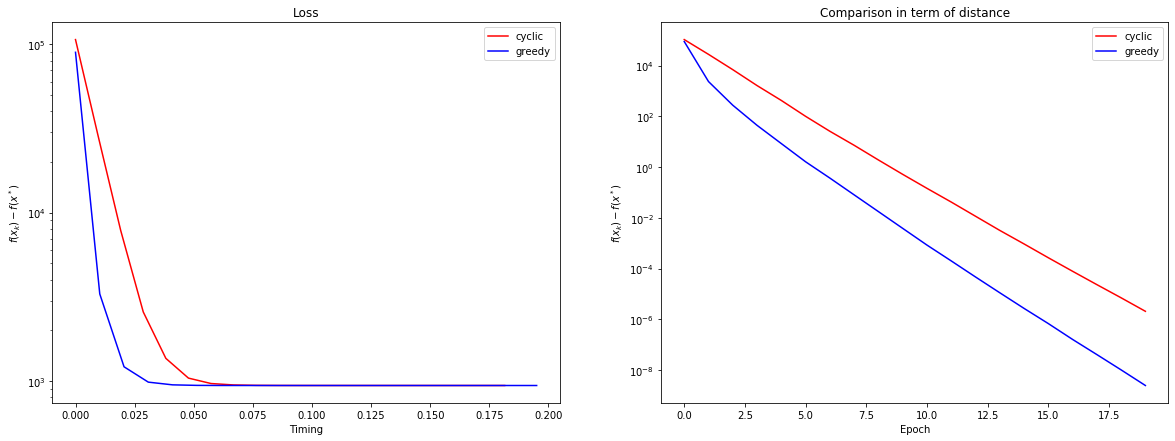

In [11]:

fig = plt.figure(1, figsize=(20, 7))
plt.subplot(1,2,1)

plt.semilogy(np.linspace(0, time_cyclic, len(o_cyclic)), o_cyclic, 'r', label='cyclic')
plt.semilogy(np.linspace(0, time_greedy, len(o_greedy)), o_greedy, 'b', label='greedy')
plt.title('Loss')
plt.xlabel('Timing')
plt.ylabel('$f(x_k) - f(x^*)$')
plt.legend()

plt.subplot(1,2,2)

plt.semilogy(o_cyclic - f_min, 'r', label='cyclic')
plt.semilogy(o_greedy - f_min, 'b', label='greedy')
plt.title('Comparison in term of distance')
plt.xlabel('Epoch')
plt.ylabel('$f(x_k) - f(x^*)$')
plt.legend()
plt.show()

- <font color='blue'>from a practical point of view, could you use greedy CD for ridge logistic regression ? to solve OLS, but with 100,000 features? Explain your answers.
</font>

*From a practical point of view, we can see that it is not efficient to use greedy cd if the number of features is too large because we are sure that we will do at least n steps to go through all cordinates(minimize on all features)*

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$
1) Assuming uniqueness of the solution, show that:
$$ \lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0$$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.


You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert (w_1)  \times \dots \times \partial \vert \cdot \vert (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert (w_j) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

<font size ='4.5' color = 'blue'>**Proof**: With uniqueness $ \lambda \geq \lambda_{max} \Leftrightarrow \hat w = \mathbf0_p$ </font>   
  


$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$
Appelons $f(\omega) = \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$


donc $\mathbf0_p \in \partial f(\hat w)$

$\partial f(w) =  \partial \left( \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1 \right)   =  \nabla \left(\sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  \right)+ \lambda \partial \Vert \cdot \Vert_1 (w) =  \sum_{i=1}^{n} \nabla \left(\mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  \right)+ \lambda \partial \Vert \cdot \Vert_1 (w) = \sum_{i=1}^{n} -\frac{e^{- y_i w^\top x_i}}{ 1 + e^{- y_i w^\top x_i}} y_i x_i + \lambda \partial \Vert \cdot \Vert_1 (w)$
$\sum_{i=1}^{n} -\frac{e^{- y_i w^\top x_i}}{ 1 + e^{- y_i w^\top x_i}} y_i x_i \in \mathbb{R}$, and let's pose $\alpha_i(w) = \frac{e^{- y_i w^\top x_i}}{ 1 + e^{- y_i w^\top x_i}}$
then
$$0 \in  \partial f(\hat w)  \iff  \sum_{i=1}^{n} \alpha_i(\hat w) y_i x_i \in \lambda \partial \Vert \cdot \Vert_1 (\hat w) $$
$\def\bigtimes{\mathop{\vcenter{\Huge\times}}}$

$$ \iff  \underset{1 \le j \le p} \bigtimes\left(\sum_{i=1}^{n} \alpha_i(\hat w) y_i x_{ij}\right) \in \lambda \underset{1 \le j \le p} \bigtimes \partial \vert \cdot \vert (\hat w_j)$$



<font color = 'blue'> $\Rightarrow$) Assume $\lambda \ge \lambda_{max}$</font> 

$$ \lambda \partial \Vert \cdot \Vert_1 (\mathbf{0}_p) = \lambda \underset{1 \le j \le p} \bigtimes \partial \vert \cdot \vert (0) = \lambda  [-1,1]^p =  [-\lambda,\lambda]^p \supset  [-\lambda_{max},\lambda_{max}]^p =  \left[-\frac 12 \Vert X^\top y \Vert_{\infty},\frac 12 \Vert X^\top y \Vert_{\infty}\right]^p $$

For  $\hat w = 0_p$ and 
$$\underset{1 \le j \le p} \bigtimes\left(\sum_{i=1}^{n} \alpha_i(\mathbf{0}_p )y_i x_{ij}\right) = \underset{1 \le j \le p} \bigtimes\left(\frac12\sum_{i=1}^{n}  y_i x_{ij}\right) \in \left[-\frac 12 \Vert X^\top y \Vert_{\infty},\frac 12 \Vert X^\top y \Vert_{\infty}\right]^p  \subset \lambda \partial \Vert \cdot \Vert_1 (\mathbf{0}_p) $$

$$\underset{1 \le j \le p} \bigtimes\left(\sum_{i=1}^{n} \alpha_i(\mathbf{0}_p )y_i x_{ij}\right) \in  \lambda \partial \Vert \cdot \Vert_1 (\mathbf{0}_p) $$

because $\forall j$, $\sum_{i=1}^{n}  y_i x_{ij} \leq \Vert X^\top y \Vert_{\infty}$

So have $\mathbf{0}_p \in \partial f(\mathbf{0}_p)$ and with the uniqueness of solution $\hat w = \mathbf{0}_p$.

<font color = 'blue'> $\Leftarrow$) Assume $\hat w = \mathbf{0}_p$</font> 

So $$\underset{1 \le j \le p} \bigtimes\left(\sum_{i=1}^{n} \alpha_i(\mathbf{0}_p )y_i x_{ij}\right) \in  \lambda \partial \Vert \cdot \Vert_1 (\mathbf{0}_p)  = [-\lambda,\lambda]^p$$

Also we have the general belonging
 $$\underset{1 \le j \le p} \bigtimes\left(\sum_{i=1}^{n} \alpha_i(\mathbf{0}_p )y_i x_{ij}\right) = \underset{1 \le j \le p} \bigtimes\left(\frac12\sum_{i=1}^{n}  y_i x_{ij}\right) \in \left[-\frac 12 \Vert X^\top y \Vert_{\infty},\frac 12 \Vert X^\top y \Vert_{\infty}\right]^p = [-\lambda_{max},\lambda_{max}]^p$$  
 
 $$\left[-\frac 12 \Vert X^\top y \Vert_{\infty},\frac 12 \Vert X^\top y \Vert_{\infty}\right]^p = \texttt{smallest hypercube centered in }\mathbf{0}_p\texttt{ which contains  } \underset{1 \le j \le p} \bigtimes\left(\frac12\sum_{i=1}^{n}  y_i x_{ij}\right) $$

And then we have  $[-\lambda_{max},\lambda_{max}]^p \subset [-\lambda,\lambda]^p$   $ \Rightarrow  \lambda \ge \lambda_{max}$.




2) Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.



Let's take $L(w) = \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} ) $ and $\phi(u)=\log(1+e^{-u})$.


Let's find an upper bound for $\phi''$

After two derivations of $\phi$ we obtain $\phi''(u)=\frac{e^u}{(1+e^u)^2}$


$\forall u \in \mathbb{R} , \left(1-e^{u}\right)^{2} \geq 0 \Rightarrow 1+e^{2 u} \geq 2 e^{u} \Rightarrow 1+e^{2 u}+2 e^{u} \geq 4 e^{u} \Rightarrow\left(1+e^{u}\right)^{2} \geq 4 e^{u} \Rightarrow \frac{e^{u}}{\left(1+e^{u}\right)^{2}}=\phi^{\prime \prime}(u) \leq \frac{1}{4}$

Then we can saw that : $\forall u,v$
$$ \left\vert \phi'(u) -\phi'(v)\right\vert \leq\frac{1}{4}\vert u-v\vert$$

Rewrite $L(w)$ according to $\phi$

 $$L(w) = \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} ) =  \sum_{i=1}^{n} \phi(-y_i w^\top x_i) $$ 

$$\nabla L(w)=\sum_{i=1}^{n} -\phi'(- y_i w^\top x_i) y_i x_i $$

We have $\forall j = 1, ..,p$
$$
\begin{align}
\left\vert\nabla_j L(w+te_j)- \nabla_j L(w)\right\vert&=\left\vert-\sum_{i=1}^{n} \phi'(- y_i (w+te_j)^\top x_i) y_i x_{ij} + \sum_{i=1}^{n} \phi'(- y_i w^\top x_i) y_i x_{ij} \right\vert \\ 
&= \left\vert\sum_{i=1}^{n}y_i x_{ij} \left(\phi'(- y_i (w+te_j)^\top x_i) -\phi'(- y_i w^\top x_i) \right) \right\vert \\
&\leq 
\sum_{i=1}^{n}\vert y_i x_{ij}\vert \left\vert\left(\phi'(- y_i (w+te_j)^\top x_i) -\phi'(- y_i w^\top x_i) \right) \right\vert \\
&\leq   \sum_{i=1}^{n}\vert y_i x_{ij}\vert \frac14\left\vert-y_i(w+te_j-w)x_i\right\vert = 
\sum_{i=1}^{n}|y_i x_{ij}| \frac14\left\vert y_ite_jx_i\right\vert \\
&=
\frac14\sum_{i=1}^{n}y_i^2 x_{ij}^2 \left\vert t\right\vert = 
\frac14\sum_{i=1}^{n} x_{ij}^2 \left\vert t\right\vert = \frac{\Vert X_j\Vert_2^2}{4}\vert t\vert
\end{align}
$$

Therfore we can take  $\gamma_j = \frac{\Vert X_j\Vert_2^2}{4}$ as lipchitz constant for the coordinate for feature $j$.



You are now ready to code cyclic proximal coordinate descent for sparse Logistic regression:

**WARNING**: the Lasso means linear regression (quadratic fitting term) with L1 penalty. Sparse logistic regression means logistic regression with L1 penalty.

In [0]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 20.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0., np.abs(x) - u)


def grad_j_logreg(x, A, b, j):
    """Logistic gradient"""
    n_samples, _ = A.shape
    Ax = A.dot(x)
    grad = 0.
    for i in range(n_samples):
      grad -= b[i] * A[i,j] * sigmoid(-b[i]*Ax[i])
    return grad

def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    all_objs = np.zeros(n_iter)
    Xw = X.dot(w)
    
    # TODO
    lips_const=[]
    for j in range(n_features):
          lips_const.append( 1/4*np.linalg.norm(X[:,j])**2)
    # END TODO
    
    for t in range(n_iter) :
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            ywX = np.array([y[i]*w @ X[i,:] for i in range(n_samples)])
            step = 1 / lips_const[j]
            grad_j = np.sum(-sigmoid(-ywX)*(1-sigmoid(-ywX))*y*X[:,j])
            w[j] = soft_thresh(old_w_j - step * grad_j, step * lamb)
            
            if old_w_j != w[j]:
                Xw += X[:,j].dot( w[j]  - old_w_j )
            #END TODO

        all_objs[t] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)
    
    return w, all_objs

In [0]:
w_logcyclic, objs_logcycl = cd_logreg(X, y, lamb, 100)

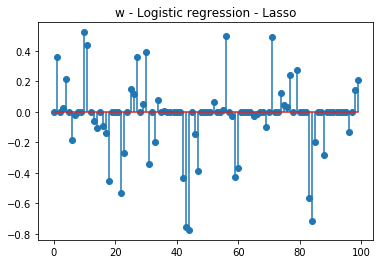

In [43]:
plt.stem(w_logcyclic,use_line_collection=True)
plt.title("w - Logistic regression - Lasso")
plt.show()

Text(0.5, 1.0, 'Logistic regression+ lasso')

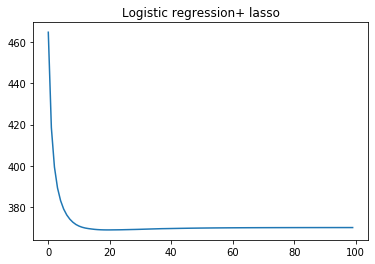

In [44]:
plt.plot(objs_logcycl)
plt.title("Logistic regression+ lasso")

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

In [0]:
from sklearn.datasets import fetch_openml

leuk = fetch_openml("leukemia")

X = np.asfortranarray(leuk.data)
y = np.ones(leuk.target.shape)
y[leuk.target == leuk.target[0]] = -1.

In [0]:
print(X.shape)

lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.

(72, 7129)


Code:
- a simple proximal gradient solver for the Lasso
- a prox CD solver for the Lasso
and compare them on this dataset. 
Do the plots in terms of epochs, not updates (to be fair to CD).

## Answers

- <font color='blue'>A simple proximal gradient solver for the Lasso. </font>

In [0]:
def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    z = lmbd*np.linalg.norm(x,ord = 1)
    return z 

def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""
    z = np.sign(x)*np.maximum(np.abs(x)-lmbd,0.)
    return z
def smoothness_const_linreg(A):
    """Lipschitz constant for least squares loss"""    
    
    return (np.linalg.norm(A,ord=2)**2)

def loss_linreg(x):
    """Least squares loss"""
    
    return np.sum(np.square(b-A.dot(x)))/(2)

def grad_linreg(x):
    """Least squares gradient"""
    
    return np.dot(A.T, A.dot(x)-b)

In [0]:
def PGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50, x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm"""
    x = x0.copy()


    # objective history
    objectives = []
    
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x_new = prox_R(x - grad_f(x)/step, lmbd/step)
        x=x_new
        obj = f(x)  + R(x, lmbd)
       
    
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives

- <font color='blue'>A prox CD solver for the Lasso
and compare them on this dataset. Do the plots in terms of epochs, not updates (to be fair to CD)</font>

In [0]:
def cd_lasso(X, y, lmbd, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    all_objs = []
    Xw = X.dot(w)
    

    lips_const = norm(X, ord=2)**2
    step = 1 / lips_const
    
    
    # current objective
    obj = 0.5 * norm(y- X.dot(w))**2 + lmbd*norm(w, ord=1)
    all_objs.append(obj)
    for t in range(n_iter) :
        for j in range(n_features):
            old_w_j = w[j]
           
            grad_j = np.dot(X[:,j].T, X.dot(w) - y)
            w[j] = soft_thresh(old_w_j - step * grad_j, step * lmbd)
            
            if old_w_j != w[j]:
                Xw += X[:,j].dot( w[j]  - old_w_j )
            
        obj = 0.5 * norm(y- X.dot(w))**2 + lmbd * norm(w, ord=1)
        all_objs.append(obj)    

    return w, all_objs

In [0]:
n_samples, n_features  = X.shape

n = n_samples
A, b = X, y
x0 = np.zeros(n_features)
coefs = np.random.randn(n_features)
n_iter = 10
#
pgd_x_hat, pgd_obj_hat = PGD(x0=x0, f=loss_linreg, grad_f=grad_linreg, R=L1_norm,
                                prox_R=prox_L1, step=smoothness_const_linreg(A), lmbd=lambd, n_iter=n_iter, x_true=coefs, verbose=False)


#
w_cdlasso, objs_cdlasso = cd_lasso(A, b, lmbd=lambd, n_iter=n_iter)

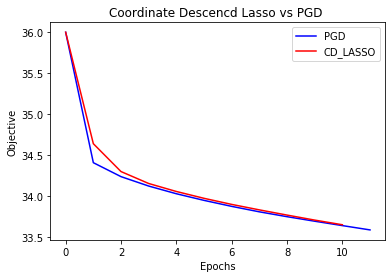

In [0]:
plt.plot(pgd_obj_hat, label='PGD', color='blue')
plt.plot(objs_cdlasso, label='CD_LASSO', color='red')
plt.title("Coordinate Descencd Lasso vs PGD ")
plt.xlabel('Epochs')
plt.ylabel('Objective')
plt.legend()
plt.show()